# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import sklearn.metrics
from collections import OrderedDict

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

Matplotlib is building the font cache; this may take a moment.


cpu


# Convolutional Neural Network - Classifiying CIFAR-10 (40 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Using downloaded and verified file: ./data/cifar-10-python.tar.gz
Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
      ship      plane        dog       bird


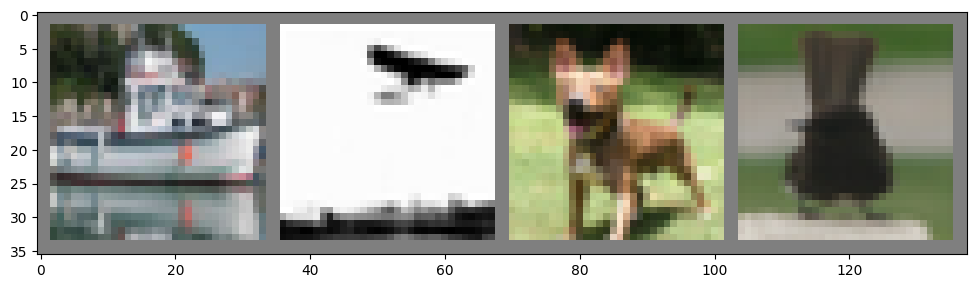

In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value. 

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class. 
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs. 
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################
         # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=64 * 4 * 4, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=10)
        
        self.logSoftMax = nn.LogSoftmax(dim = 1)
        # Activation function
        self.relu = nn.ReLU()
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.logSoftMax(x)
        return x
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Net()
criterion = None
optimizer = None
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   # 
#############################################################################
criterion = nn.CrossEntropyLoss()

# Adam optimizer, similar to SGD but uses an adaptive learning rate and adaptive gradient scaling technique
optimizer = optim.Adam(net.parameters(), lr=1e-3)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [7]:
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        # 
#############################################################################
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the number of epochs
num_epochs = 10

# Check if a GPU is available and set the device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize lists to store the train/test losses and accuracies
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Train the model
for epoch in range(num_epochs):
    # Training loop
    net.train()
    train_loss = 0
    train_correct = 0
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, pred = outputs.max(1)
        train_correct += pred.eq(labels).sum().item()


    # Append the train/test losses and accuracy to the lists
    train_losses.append(train_loss / len(trainloader))
    train_accuracies.append(train_correct / len(trainset))

    # Print the loss and accuracy for each epoch
    print(f'Epoch {epoch+1}: train loss = {train_losses[-1]:.4f}, train accuracy = {train_accuracies[-1]:.4f}')

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Epoch 1: train loss = 1.4449, train accuracy = 0.4728
Epoch 2: train loss = 1.0550, train accuracy = 0.6265


KeyboardInterrupt: 

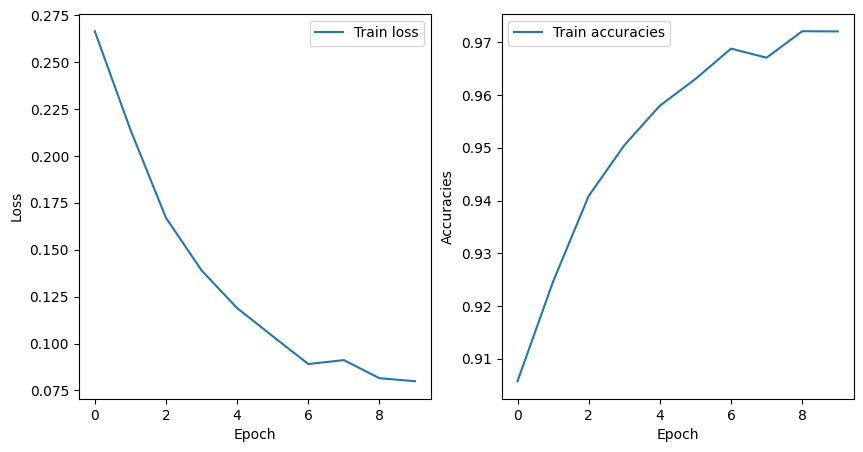

In [10]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot the train losses in the first subplot
ax1.plot(train_losses, label='Train loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the train accuracies in the second subplot
ax2.plot(train_accuracies, label='Train accuracies')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracies')
ax2.legend()

# Show the plo

## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. **(10 points)** 

In [11]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################
test_predictions = []
test_labels = []

net.eval()
with torch.no_grad():

  for data,labels in testloader:
    data = data.to(device)
    labels = labels.to(device)
    logits = net(data)
    _, predictions = logits.max(1)

    test_labels.extend(list(labels.cpu().numpy()))
    test_predictions.extend(list(predictions.cpu().numpy()))

model_accuracy = np.sum(np.array(test_labels) == np.array(test_predictions))/len(test_labels)

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)
for i in range(10):
  for j in range(10):

    idxmask = test_labels==i
    jdxmask = test_predictions==j
    
    s= np.sum(idxmask*jdxmask)
    
    confusion_matrix[i,j] = s

model_accuracy = model_accuracy * 100 
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy))

Model accuracy on 10000 test images: 71.46%


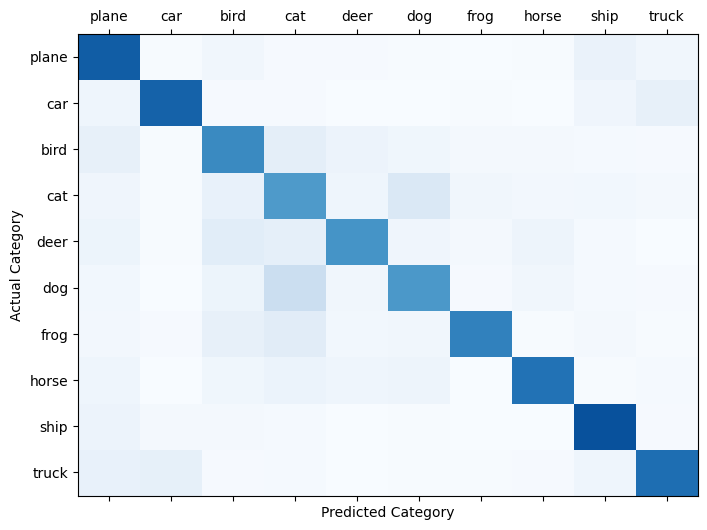

In [12]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

##**Question:** 
Describe your experiments.
What parameters have you experimented with? What works and what doesn't? Why?   **(5 Points)**

**Your answer:** *Fill this in*

##**Question:** 
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

**Your answer:** *Fill this in*

# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images. 

In [13]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [14]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [19]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


In [20]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1200x800 with 0 Axes>

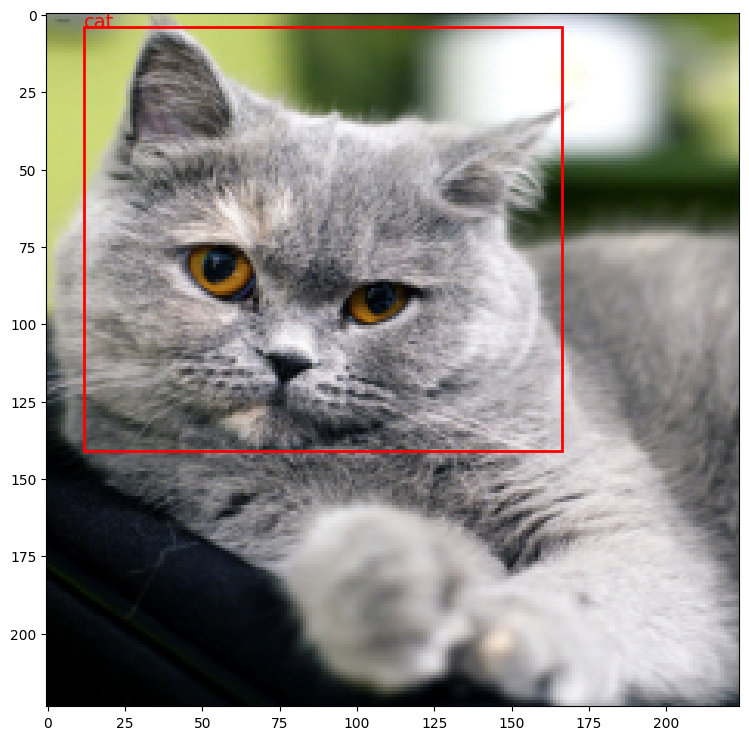

In [21]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [28]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only       #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # Clarrification - You required to build 2 models - one for classification  #
        # and one for detection.                                                    #
        # The classification model is of shape: resent_features -> FC/FCs -> scores.#
        # The detection model is of shape: resent_features -> FC/FCs -> bbox.       #
        # You may train/leave frozen the resent_features backbone, try              #
        # experimenting with it.                                                    #
        # This function has no return value.                                        #
        #############################################################################
        self.resnet = resnet18

        # Freeze the weights of the pre-trained ResNet-18 model
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Replace the top fc layer with a new layer with the specified number of output classes
        fc_in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(fc_in_features, fc_in_features)

        # Define the class scores model
        self.class_scores = nn.Linear(fc_in_features, num_classes)

        # Define the bounding box coordinates model, 4 output dimensions for the
        # bounding box coordinates (x, y, w, h)
        #self.bbox_coords = nn.Linear(fc_in_features, 4)
        self.bbox_coords = nn.Sequential(OrderedDict([
                             ('fc1', nn.Linear(fc_in_features, fc_in_features//2)),
                             ('relu1', nn.ReLU()),
                             ('fc2', nn.Linear(fc_in_features//2, fc_in_features//4)),
                             ('relu2', nn.ReLU()),
                             ('fc3', nn.Linear(fc_in_features//4, 4))
                           ]))
        # Define val/train loss/acc/iou history
        self.train_loss_history = []
        self.train_accuracy_history = []
        self.train_iou_history = []
        self.val_loss_history = []
        self.val_accuracy_history = []
        self.val_iou_history = []
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################
         # Pass the input images through the pre-trained ResNet-18 network
        features = self.resnet(images)

        # Predict the class scores using the class scores model
        class_scores = self.class_scores(features)

        # Predict the bounding box coordinates using the bounding box coordinates model
        bbox_coords = self.bbox_coords(features)

        return class_scores, bbox_coords
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set. 
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

In [29]:
def calculate_metrics(preds, labels, bbox_coords, bboxes, dataset_size):
    """Calculate accuracy and IoU metrics."""
    running_corrects = torch.sum(preds == labels.data)
    accuracy = running_corrects.double() / dataset_size
    
    iou_score = sum(bb_intersection_over_union(bbox_coords[i], bboxes[i]) 
                   for i in range(len(bboxes)))
    iou_score = iou_score.item() / dataset_size
    
    return accuracy, iou_score

def update_history(model, phase, loss, accuracy, iou):
    """Update model's history with training/validation metrics."""
    if phase == 'train':
        model.train_loss_history.append(loss)
        model.train_accuracy_history.append(accuracy.to("cpu"))
        model.train_iou_history.append(iou)
    else:
        model.val_loss_history.append(loss)
        model.val_accuracy_history.append(accuracy.to("cpu"))
        model.val_iou_history.append(iou)

def train_batch(model, images, labels, bboxes, optimizer, criterion_cls, criterion_bbox):
    """Train model on a single batch."""
    optimizer.zero_grad()
    
    # Forward pass
    class_scores, bbox_coords = model(images)
    
    # Calculate losses
    loss_cls = criterion_cls(class_scores, labels)
    loss_bbox = criterion_bbox(bbox_coords, bboxes)
    total_loss = (0.025 * loss_cls) + loss_bbox
    
    # Backward pass
    total_loss.backward()
    optimizer.step()
    
    # Get predictions
    _, preds = torch.max(class_scores, 1)
    
    return total_loss, preds, bbox_coords

def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}\n{"-" * 10}')

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            
            # Iterate over data
            for sample in dataloaders[phase]:
                images = sample['image'].to(device)
                labels = sample['label'].to(device)
                bboxes = sample['bbox'].to(device)
                
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train':
                        loss, preds, bbox_coords = train_batch(
                            model, images, labels, bboxes, 
                            optimizer, criterion_cls, criterion_bbox
                        )
                    else:
                        class_scores, bbox_coords = model(images)
                        _, preds = torch.max(class_scores, 1)
                        loss_cls = criterion_cls(class_scores, labels)
                        loss_bbox = criterion_bbox(bbox_coords, bboxes)
                        loss = (0.025 * loss_cls) + loss_bbox
                
                running_loss += loss.item() * images.size(0)
                
            # Calculate epoch metrics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc, epoch_iou = calculate_metrics(
                preds, labels, bbox_coords, bboxes, dataset_sizes[phase]
            )
            
            # Update history
            update_history(model, phase, epoch_loss, epoch_acc, epoch_iou)
            
            print(f'{phase} Loss: {epoch_loss:.4f}  |  Acc: {epoch_acc:.4f}  |  IOU: {epoch_iou:.4f}')
            
            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [31]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [32]:
best_model = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.0481  |  Acc: 0.0425  |  IOU: 0.0318
val Loss: 0.0314  |  Acc: 0.1899  |  IOU: 0.1308
Epoch 2/10
----------
train Loss: 0.0247  |  Acc: 0.0440  |  IOU: 0.0338
val Loss: 0.0214  |  Acc: 0.1835  |  IOU: 0.1400
Epoch 3/10
----------
train Loss: 0.0209  |  Acc: 0.0425  |  IOU: 0.0333
val Loss: 0.0231  |  Acc: 0.1899  |  IOU: 0.1449
Epoch 4/10
----------
train Loss: 0.0186  |  Acc: 0.0440  |  IOU: 0.0332
val Loss: 0.0207  |  Acc: 0.1835  |  IOU: 0.1424
Epoch 5/10
----------
train Loss: 0.0184  |  Acc: 0.0440  |  IOU: 0.0333
val Loss: 0.0178  |  Acc: 0.1899  |  IOU: 0.1486
Epoch 6/10
----------
train Loss: 0.0154  |  Acc: 0.0440  |  IOU: 0.0337
val Loss: 0.0174  |  Acc: 0.1899  |  IOU: 0.1480
Epoch 7/10
----------
train Loss: 0.0158  |  Acc: 0.0440  |  IOU: 0.0339
val Loss: 0.0175  |  Acc: 0.1899  |  IOU: 0.1442
Epoch 8/10
----------
train Loss: 0.0140  |  Acc: 0.0440  |  IOU: 0.0344
val Loss: 0.0181  |  Acc: 0.1899  |  IOU: 0.1466
Epoch 9/10
----------
tr

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

<Figure size 1200x800 with 0 Axes>

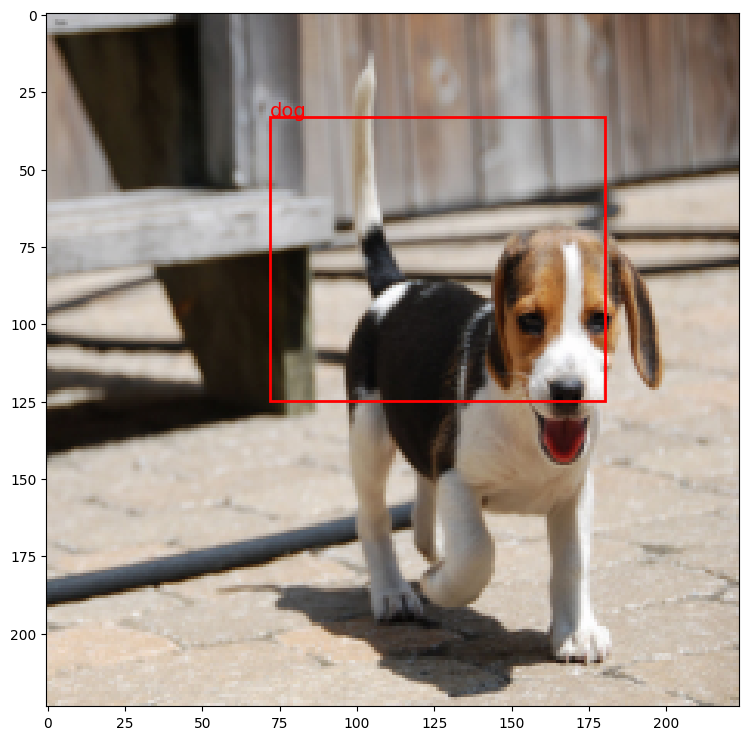

In [33]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

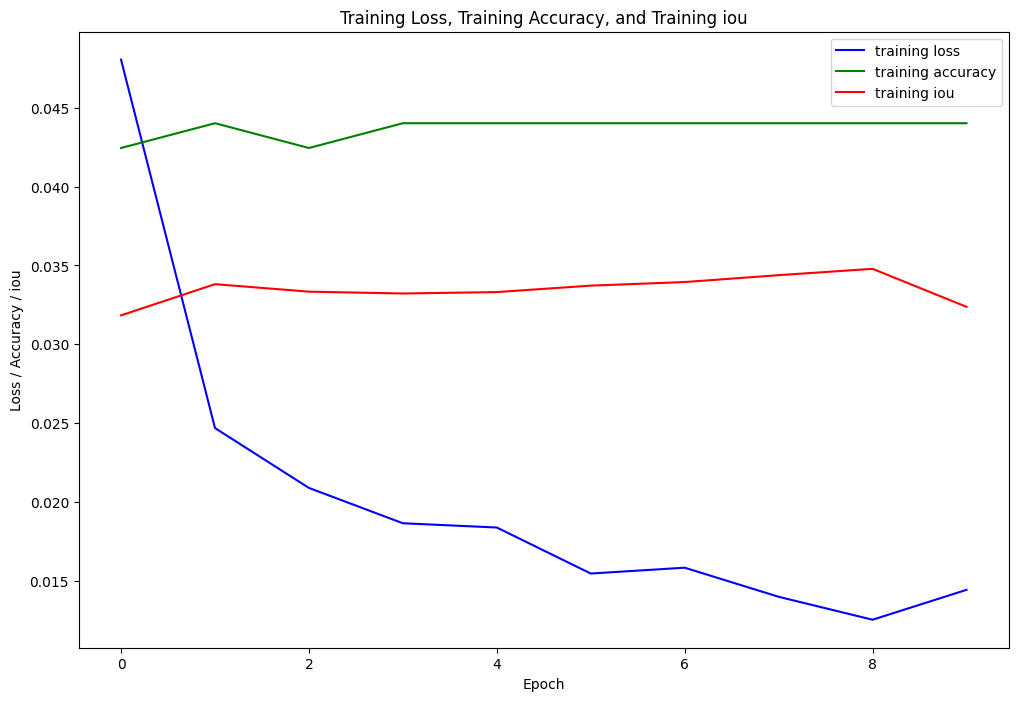

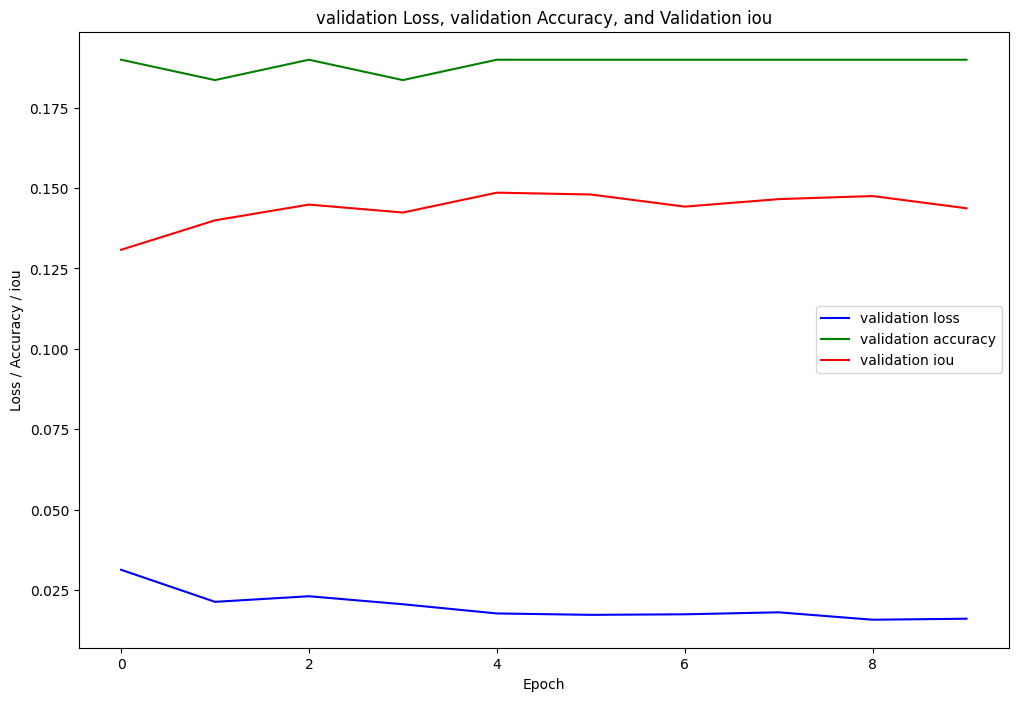

In [34]:
# plot best model iou/accuracy/loss history on training and validation.

import matplotlib.pyplot as plt

# Plot the training loss, training accuracy, and training iou on the same plot
plt.plot(best_model.train_loss_history, label='training loss', color='blue', linestyle='solid')
plt.plot(best_model.train_accuracy_history, label='training accuracy', color='green', linestyle='solid')
plt.plot(best_model.train_iou_history, label='training iou', color='red', linestyle='solid')

# Add a title, x-axis label, and y-axis label
plt.title('Training Loss, Training Accuracy, and Training iou')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy / iou')

# Add a legend and show the plot
plt.legend()
plt.show()

# Plot the validation loss, validation accuracy, and validation iou on the same plot
plt.plot(best_model.val_loss_history, label='validation loss', color='blue', linestyle='solid')
plt.plot(best_model.val_accuracy_history, label='validation accuracy', color='green', linestyle='solid')
plt.plot(best_model.val_iou_history, label='validation iou', color='red', linestyle='solid')

# Add a title, x-axis label, and y-axis label
plt.title('validation Loss, validation Accuracy, and Validation iou')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy / iou')

# Add a legend and show the plot
plt.legend()
plt.show()